# Todo
[x] remove hum over 70 before resampling

In [1]:
from dask import dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from functools import reduce
import seaborn as sns
from sklearn import preprocessing
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from random import randrange

from random import seed
from random import random
from matplotlib import pyplot
import pandas
from pandas.plotting import autocorrelation_plot
from keras import Model
from keras.layers import GRU, Dense, Input, Dropout, LSTM, concatenate
%matplotlib inline

from numpy.random import seed as np_seed
from tensorflow import set_random_seed
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback

from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

SEED = 42

seed(SEED)
np_seed(SEED)
set_random_seed(SEED)


path = '../data/'




Using TensorFlow backend.


In [2]:
df_sds011 = dd.read_csv(path + 'processed*sds011*').compute()
df_dht22 = dd.read_csv(path + 'processed*dht22*').compute()

df_sds011['timestamp'] = pd.to_datetime(df_sds011['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_dht22['timestamp'] = pd.to_datetime(df_dht22['timestamp'], format='%Y-%m-%dT%H:%M:%S')


#Problems when remove index category because of multi index
#df_sds011['location'] = df_sds011['location'].astype('category')
#df_dht22['location'] = df_dht22['location'].astype('category')

df_sds011 = df_sds011.set_index(['location', 'timestamp'])
df_dht22 = df_dht22.set_index(['location', 'timestamp'])

df_sds011 = df_sds011.sort_index()
df_dht22 = df_dht22.sort_index()

df_sds011 = df_sds011[['P1', 'P2']]
df_dht22 = df_dht22[['temperature', 'humidity']]

df_cars = pd.read_csv('../cars.csv', sep=';', header=None, names=['timestamp', 'n_cars'])
df_cars['timestamp'] = pd.to_datetime(df_cars['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_cars = df_cars.set_index(df_cars.timestamp, drop=True)
df_cars = df_cars.drop(columns=['timestamp'])
df_cars = df_cars.sort_index()
#df = df.groupby((pd.Grouper(freq='60min', level=0))).sum()

In [ ]:
print(df_sds011.shape)
print(df_dht22.shape)
print(df_cars.shape)
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())
print(df_cars.isnull().sum())

In [ ]:
df_sds011.describe()

In [ ]:
df_dht22.describe()

In [ ]:
df_dht[df_dht.index > ]

3642
Q3 99.9 Q1 53.3 fence_low -16.60000000000001 fence_high 169.8
6367
Q3 99.5 Q1 44.9 fence_low -37.00000000000001 fence_high 181.4
8732
Q3 84.3 Q1 62.5 fence_low 29.800000000000004 fence_high 117.0
10574
Q3 98.0 Q1 82.0 fence_low 58.0 fence_high 122.0


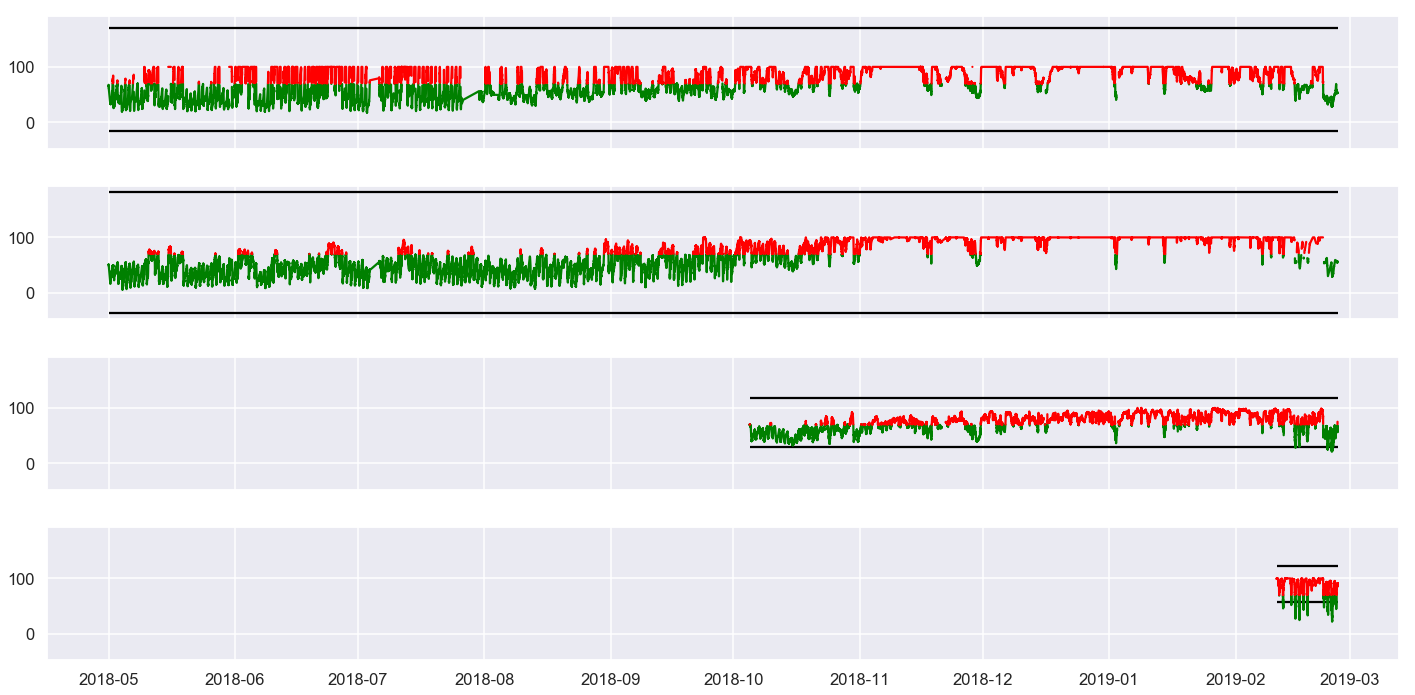

In [120]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10), sharex=True, sharey=True)

for idx, (loc, loc_df) in enumerate(df_dht22[df_dht22.index.get_level_values(1) > '2018-05-01'].groupby('location')):
    print(loc)

    upper = 70#50
    lower = 0#20

    s = loc_df['humidity']
    t = loc_df.index.get_level_values(1)
    
    supper = np.ma.masked_where(s < upper, s)
    slower = np.ma.masked_where(s > lower, s)
    smiddle = np.ma.masked_where(np.logical_or(s < lower, s > upper), s)

    q3 = s.quantile(.75)
    q1 = s.quantile(.25)

    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr # mild outlier
    fence_high = q3+1.5*iqr # mild outlier

    print('Q3', q3, 'Q1', q1, 'fence_low', fence_low, 'fence_high', fence_high)

    axes[idx].plot(t, smiddle, 'green', t, slower, 'red', t, supper, 'red')
    axes[idx].hlines(y=fence_high, xmin=t.min(), xmax=t.max(),color='black', linestyle='-')
    axes[idx].hlines(y=fence_low, xmin=t.min(), xmax=t.max(),color='black', linestyle='-')

    plt.tight_layout()


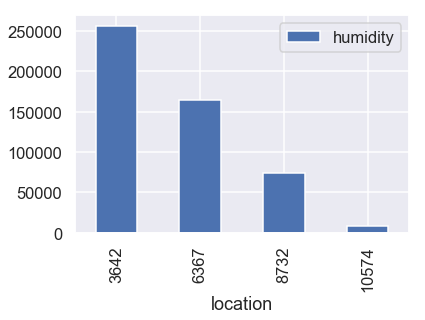

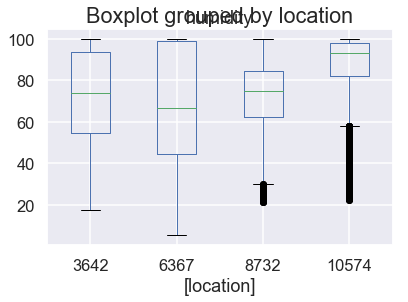

In [119]:
import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style('darkgrid')

plot = df_dht22.groupby(level=0)[['humidity']].count().plot(kind="bar")
fig = plot.get_figure()
fig.savefig("output.pdf")

_ = df_dht22[['humidity']].boxplot(by='location')

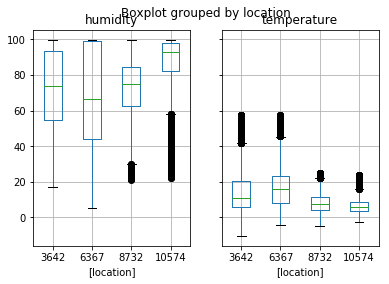

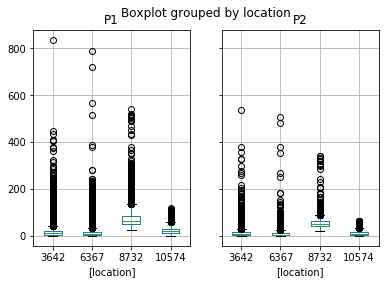

In [3]:
_ = df_dht22.boxplot(by='location')
_ = df_sds011.boxplot(by='location')

In [ ]:
df_dht22.groupby(level=0)[['humidity']].plot(kind='kde')

In [ ]:
df_sds011.groupby(level=0).plot(kind='kde')

In [ ]:
df_dht22.groupby(level=0).plot( kind='kde')

In [ ]:
print(df_sds011.groupby(level=0).count())
print(df_dht22.groupby(level=0).count())

# Drop unnecessary  data 

In [ ]:
df_sds011 = df_sds011.drop([3123, 10574], level=0)
df_dht22 = df_dht22.drop([3123, 10574], level=0)
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())

# Outliers

In [ ]:
def remove_outlier(df):
    res = df[np.abs(df - df.mean()) <= (3*df.std())]
    #print(res.groupby(level=0).count())
    return res.dropna()


print(df_sds011.shape)
print(df_dht22.shape)

df_sds011 = remove_outlier(df_sds011)
df_dht22 = remove_outlier(df_dht22)

print(df_sds011.shape)
print(df_dht22.shape)

print('NaNs')
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())

In [ ]:
df_sds011.describe()

In [ ]:
df_dht22.describe()

In [ ]:
_ = df_dht22.boxplot(by='location')
_ = df_sds011.boxplot(by='location')

In [ ]:
df_sds011.groupby(level=0).hist(bins=30)

In [ ]:
df_dht22.groupby(level=0).plot(kind='kde')

In [ ]:
df_sds011.groupby(level=0).describe()

In [ ]:
df_dht22.groupby(level=0).describe()

In [ ]:
from scipy.stats import probplot
print(df_sds011.shape)
print('----------------')
temp = df_dht22.groupby(level=1).mean().sort_index()
print(temp.shape)
print(temp.isnull().sum())

from scipy.stats import loggamma

fig = plt.figure()
ax = fig.add_subplot(111)

print(temp['humidity'].describe())
probplot(temp['humidity'].values, plot=ax)



#np.mean(preprocessing.normalize(temp['P1'].values.reshape(1,-1))), np.std(preprocessing.normalize(temp['P1'].values.reshape(1,-1)))

# Resample and Merge

In [ ]:
#def resample(df, freq='60min'):
#    level_values = df.index.get_level_values
#    return df.groupby([level_values(0)] + [pd.Grouper(freq=freq, level=1)]).mean().dropna()

In [ ]:
## Grenzwert ermittlung von PM10 und PM2.5 für Tagesmittelwerte und Jahresmittelwerte 
df_sds011 = df_sds011.groupby(level=1).mean().sort_index()
df_dht22 = df_dht22.groupby(level=1).mean().sort_index()


day_sds = df_sds011.groupby(pd.Grouper(freq='1D', level=0)).mean().dropna()
day_dht = df_dht22[df_dht22.humidity <= 70.0].groupby(pd.Grouper(freq='1D', level=0)).mean().dropna()

year_sds = df_sds011.groupby(pd.Grouper(freq='1Y', level=0)).mean().dropna()
year_dht = df_dht22[df_dht22.humidity <= 70.0].groupby(pd.Grouper(freq='1Y', level=0)).mean().dropna()

year = pd.merge(year_sds, year_dht, left_index=True, right_index=True, how='inner')
print(year)


print(df_dht22[df_dht22.humidity <= 70.0].shape, df_dht22.shape)

print(day_sds.index.min(), day_sds.index.max())
print(day_dht.index.min(), day_sds.index.max())
print(day_sds.shape, day_dht.shape)

day = pd.merge(day_sds, day_dht, left_index=True, right_index=True, how='inner')
print(day.shape)
print(day.isnull().sum())
print(day.shape)

print('P10: ', day[day['P1'] > 50].shape)
print('P2.5: ', day[day['P2'] > 25].shape)


In [ ]:
print(df_sds011.shape)
print(df_dht22.shape)

df_sds011 = df_sds011.groupby(level=1).mean().sort_index()
df_dht22 = df_dht22.groupby(level=1).mean().sort_index()

df_sds011 = df_sds011.groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()
df_dht22 = df_dht22[df_dht22.humidity <= 70].groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()

print(df_sds011.shape)
print(df_dht22.shape)

#print(temp.describe())
#print(temp.shape)
#temp = temp.groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()
#print(temp.shape)
#print(temp.describe())


#temp = temp[temp.index < '2018-11-16']
#temp = temp[temp.humidity <= 70.0]

#bound = 70#50

#s = temp.humidity
#t = temp.index

#supper = np.ma.masked_where(s >= bound, s)
#srest = np.ma.masked_where(s < bound, s)

#fig, axes = plt.subplots(nrows=1, ncols=1)
#axes.plot(t, srest, 'red', t, supper, 'green')
    
    
#fig = plt.figure()
#ax = fig.add_subplot(111)
#probplot(temp['temperature'].values, plot=ax)


In [ ]:

#df_sds011 = resample(df_sds011)
#df_dht22 = resample(df_dht22)

In [ ]:
#data = pd.merge(df_sds011, df_dht22, left_index=True, right_index=True, how='inner')
#print(data[data.humidity <= 70.0].describe())
#print(data[data.humidity > 70.0].describe())

#data[data.humidity <= 70.0][['P1']].hist(bins=30)
#data[data.humidity > 70.0][['P1']].hist(bins=30)

In [ ]:
print(df_sds011.shape, df_dht22.shape)

In [ ]:
data = pd.merge(df_sds011, df_dht22, left_index=True, right_index=True, how='inner')
print(data.isnull().sum())
print(data.shape)
data.head()

In [ ]:
# data = data[data.index < '2018-11-16']
data.plot()

In [ ]:

alpha = list(data.columns.values)

fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(data.corr(), interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()



In [ ]:
df_dht22[['temperature']].hist(bins=50, by='location')

In [ ]:
df_dht22[['humidity']].hist(bins=50, by='location')

In [ ]:
bins = int(len(range(int(df_sds011['P1'].min()), int(df_sds011['P1'].max()))) / 5 )
df_sds011[['P1']].hist(bins=bins, by='location')

In [ ]:
#bins = int(len(range(int(df_sds011['P2'].min()), int(df_sds011['P2'].max()))) / 5 )
bins = 50

f, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True)

groups = list(df_sds011.groupby(level=0))


sns.distplot(groups[0][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,0])

axes[0,0].title.set_text(groups[0][0])

sns.distplot(groups[1][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,1])

axes[0,1].title.set_text(groups[1][0])

sns.distplot(groups[2][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,0])

axes[1,0].title.set_text(groups[2][0])


    
plt.tight_layout()
    


In [ ]:
#bins = int(len(range(int(df_sds011['P2'].min()), int(df_sds011['P2'].max()))) / 5 )
bins = 15


f, axes = plt.subplots(3, 2, figsize=(10, 7), sharex=True)

#data gets average over location 

#d = data[data['P1'] <= 15]
d = data
sns.distplot(d[['P1']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,0])

axes[0,0].title.set_text('P1')

sns.distplot(d[['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,1])

axes[0,1].title.set_text('P2')


sns.distplot(boxcox(d[['P1']], lmbda=0), hist=False, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,0])

axes[1,0].title.set_text('P1 boxcox')

sns.distplot(boxcox(d[['P2']], lmbda=0), hist=False, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,1])

axes[1,1].title.set_text('P2 boxcox')

sns.distplot(d[['temperature']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[2,0])

axes[2,0].title.set_text('Temperature')

sns.distplot(d[['humidity']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[2,1])

axes[2,1].title.set_text('Humidity')

    
plt.tight_layout()
    

# Add add car features

In [ ]:
df_cars = df_cars.groupby(pd.Grouper(freq='60min', level=0)).sum()
df_cars.shape

In [ ]:
car_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
df_cars['n_cars'] = car_scaler.fit_transform(df_cars['n_cars'].values.reshape(-1,1).astype('float'))
df_cars.head()

# Add date features

In [ ]:


day_of_week = lambda x: x.weekday()
week_number = lambda x: x.strftime('%V')
hour = lambda x: x.hour

#t = df_sds011.groupby(pd.Grouper(freq='60min', level=1)).mean().dropna()

#t.index.map(hour)[0:5]


cat_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')

day_of_week = data.index.map(day_of_week).astype('int')
week_number = data.index.map(week_number).astype('int')
hour = data.index.map(hour).astype('int')


day_of_week = cat_scaler.fit_transform(onehot_encoder.fit_transform(day_of_week.values.reshape(-1,1)))
week_number = cat_scaler.fit_transform(onehot_encoder.fit_transform(week_number.values.reshape(-1,1)))
hour = cat_scaler.fit_transform(onehot_encoder.fit_transform(hour.values.reshape(-1,1)))
date_features = np.concatenate([day_of_week, week_number, hour], axis=1)

df_date = pd.DataFrame(date_features, index=data.index)
df_date.head()

# Time Series

In [ ]:

 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
#remove location as index, leaving only timestamp

#data = data.groupby(level=1).mean().sort_index()[['P1', 'P2', 'temperature', 'humidity']]
#data = data[['humidity', 'temperature', 'P1']]
data = data[['temperature', 'P1']]
data = series_to_supervised(data, n_in=1, n_out=1, dropnan=True)
data.head()

In [ ]:
data['diff2-1'] = data['var2(t)'] - data['var2(t-1)']
#data['diff2-2'] = data['var2(t)'] - data['var2(t-2)']
#data['diff2-3'] = data['var2(t)'] - data['var2(t-3)']

data['diff1-1'] = data['var1(t)'] - data['var1(t-1)']
#data['diff1-2'] = data['var1(t)'] - data['var1(t-2)']
#data['diff1-3'] = data['var1(t)'] - data['var1(t-3)']

data.head()

In [ ]:

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit_transform(data)
data = DataFrame(scaler, index=data.index, columns=data.columns)
data.head()

# Combine Sensor Features with Date Features / Car Data

In [ ]:
data = pd.merge(data, df_date, left_index=True, right_index=True, how='inner')
print(data.shape)
data.head()

In [ ]:
car_data = pd.merge(df_cars, data, left_index=True, right_index=True, how='inner')
print(car_data.shape)
car_data.head()


In [ ]:
#X_train.shape[-1]

def create_model(batch_size, dim, stateful=True):
    if batch_size:
        inp = Input(batch_shape=(batch_size,1, dim))
    else:
        inp = Input(shape=(1,dim,))
    x = GRU(50, stateful=stateful, return_sequences=False)(inp)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='sigmoid')(x)
    x = Dropout(0.2)(x)
    clf = Dense(1)(x)

    model = Model(inp, clf)
    feature_extractor = Model(inp, x)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model, feature_extractor

def create_pre_trained_model(old_model):
    feature_extractor = Model(old_model.inputs, old_model.layers[-2].output)  

    for l in feature_extractor.layers:
        l.trainable = False

    inp_car = Input(shape=(1,))
    x = Dense(5, name='car-features')(inp_car)
    x = Dropout(0.2)(x)
    x = concatenate([feature_extractor.output, x])
    x = Dense(1, activation='sigmoid')(x)
    new_model = Model(inputs=[feature_extractor.input, inp_car], outputs=x)
    new_model.compile(loss='mean_squared_error', optimizer='adam')
    return new_model

def create_data(train, test):
    """
    Train and Test parameters are pandas DataFrames.
    """
    y_train = train[['var2(t)']].values
    X_train = train.drop(columns=['var2(t)']).values

    X_test = test.drop(columns=['var2(t)']).values
    y_test = test[['var2(t)']].values

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_train, X_test, y_train, y_test

def predict_baseline(train, test):
    """
    Train and Test parameters are pandas DataFrames.
    """
    ### Persistence Baseline
    baseline = mean_squared_error(test['var2(t-1)'].values, test['var2(t)'].values)
    print('Persistence Baseline %.6f' % baseline)
    return baseline, test[['var2(t-1)', 'var2(t)']]


def train_normal(X_train, X_test, y_train, y_test):
    model, _ = create_model(None, X_train.shape[-1], stateful=False)
    model.fit(X_train, y_train, epochs=50000, shuffle=True, batch_size=len(X_train), validation_data=(X_test, y_test), callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True, show_inner=False)], verbose=0)
    return model, model

def train_timeseries(X_train, X_test, y_train, y_test):
    train_model, _= create_model(len(X_train), X_train.shape[-1])
    test_model, _ = create_model(len(X_test), X_train.shape[-1])

    pbar = tqdm(range(10000), leave=True)

    for i in pbar:
        train_model.fit(X_train, y_train, epochs=1, shuffle=False, batch_size=len(X_train), verbose=0)
        train_model.reset_states()

        test_model.set_weights(train_model.get_weights())
        r = test_model.evaluate(X_test, y_test, batch_size=len(X_test), verbose=0)
        pbar.set_description("Test: %.6f" % r)
    return train_model, test_model


def train_predict_pretrained(X_train, X_car_train, X_test, X_car_test, y_train, y_test, model):
    hist = model.fit([X_train, X_car_train], y_train, epochs=5000, shuffle=True, batch_size=(len(X_train)), validation_data=([X_test, X_car_test], y_test), callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True, show_inner=False)], verbose=0)
    
    pred = model.predict([X_test, X_car_test], batch_size=len(X_test))
    mse = mean_squared_error(pred.reshape(pred.shape[0]),  y_test)
    
    df = pd.DataFrame(index=test.index)
    df['pred'] = pred.reshape(pred.shape[0])
    df['true'] = y_test
    
    return mse, df, model, hist

def predict(X_train, X_test, y_train, y_test, train_fn):

    result = {}

    train_model, test_model = train_fn(X_train, X_test, y_train, y_test)

    pred = test_model.predict(X_test, batch_size=len(X_test))
    mse = mean_squared_error(pred.reshape(pred.shape[0]),  y_test)
        
    df = pd.DataFrame(index=test.index)
    df['pred'] = pred.reshape(pred.shape[0])
    df['true'] = y_test
    
    
    return mse, df, train_model, test_model


def plot_eval(df, test):
    test[['var2(t-1)', 'var2(t)']].plot(figsize=(25,5))
    df.plot(figsize=(25,5))

kfold = KFold(5, shuffle=False, random_state=SEED)

results_ts = []
results_norm = []
for train, test in kfold.split(data):
    
    train, test = data.iloc[train], data.iloc[test]
    baseline, baseline_df = predict_baseline(train, test)
    
    X_train, X_test, y_train, y_test = create_data(train, test)
    
    #TODO plot history
    
    mse, df, train_model, test_model = predict(X_train, X_test, y_train, y_test, train_timeseries)
    results_ts.append((baseline, mse, baseline_df, df, train_model, test_model, test))
    
    mse, df, train_model, test_model = predict(X_train, X_test, y_train, y_test, train_normal)
    results_norm.append((baseline, mse, baseline_df, df, train_model, test_model, test))

    

def print_res(results):
    print('Baseline mse %.5f (%.5f STD)' % (np.mean(results[:,0]), np.std(results[:,0])))
    print('Model mse %.5f (%.5f STD)' % (np.mean(results[:,1]), np.std(results[:,1])))
    
    
results_ts = np.asarray(results_ts)
results_norm = np.asarray(results_norm)
 
print_res(results_ts)
print_res(results_norm)

models = results_norm[:, -3]

results_pt_norm = []
for train, test in kfold.split(car_data):
    
    train, test = car_data.iloc[train], car_data.iloc[test]

    X_car_train = train['n_cars'].values
    X_car_test = test['n_cars'].values

    train = train.drop(columns=['n_cars'])
    test = test.drop(columns=['n_cars'])

    X_train, X_test, y_train, y_test = create_data(train, test)
    
    for model in models:


        pretrained_model = create_pre_trained_model(model)

        mse, df, pretrained_model, hist = train_predict_pretrained(X_train, X_car_train, X_test, X_car_test, y_train, y_test, pretrained_model)
        print(mse)

        results_pt_norm.append((mse, df, pretrained_model, hist))
    
    
results_pt_norm = np.asarray(results_pt_norm)

In [ ]:
print(np.mean(results_pt_norm[:, 0]))
print(np.std(results_pt_norm[:, 0]))

print_res(results_ts)
print_res(results_norm)

In [ ]:
print_res(results_ts)
print_res(results_norm)

In [ ]:
print(results_ts[:,0])
print(results_ts[:,1])
print(results_norm[:,1])

In [ ]:
plot_eval(results_ts[0][3], results_ts[0][-1])

In [ ]:
plot_eval(results_norm[4][3], results_norm[4][-1])

Performance

Baseline mse 0.00447 (0.00250 STD)  
Model mse 0.03598 (0.03145 STD)  
Baseline mse 0.00447 (0.00250 STD)  
Model mse 0.00182 (0.00102 STD)  

# Check for Random Walk, Stationarity ...

In [ ]:


seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
#pyplot.plot(random_walk)
autocorrelation_plot(random_walk)
pyplot.show()

In [ ]:

series = [randrange(10) for i in range(1000)]
autocorrelation_plot(series)


In [ ]:

# statistical test
result = adfuller(d['temperature'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [ ]:
autocorrelation_plot(d['temperature'])

In [ ]:
values = []
for t in range(1, len(d['P1'])):
    value = d['P1'].values[t] - d['P1'].values[t - 1]
    values.append(value)

#pyplot.plot(values)
#pyplot.show()
autocorrelation_plot(values)